[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Olesik_et_al_2022/demo_analytical_solution.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Olesik_et_al_2022/demo_analytical_solution.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Olesik_et_al_2022/demo_analytical_solution.ipynb)

see [Olesik et al. 2022](https://doi.org/10.5194/gmd-15-3879-2022)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import math
import numpy as np
from matplotlib import pyplot
from scipy import optimize, integrate
import pint

In [3]:
si = pint.UnitRegistry()
si.setup_matplotlib()
t_unit = si.s
r_unit = si.um
p_unit = r_unit **2
n_unit = si.cm ** -3 / r_unit

def mgn(quantity, unit):
    return quantity.to(unit).magnitude

In [4]:
rho_w = 1 * si.kg / si.dm ** 3
rho_a = 1 * si.kg / si.m ** 3

r_min = 1 * si.um
r_max = 25 * si.um
nr = 100
mixing_ratios = np.array([1, 4,10])

ksi_0 = 100 * si.um ** 2 / si.s
S = 1.00075
ksi = (S - 1)* ksi_0
def drdt(r):
    return ksi / r  

def unnormalised_pdf(r):
    return ((700 / si.cm**3 * si.um) / r *
                np.exp(- 22 * (np.log10(r / (7 * si.um)) ** 2)) *
                (1 / si.um))

def mixing_ratio(arg):
    r_min = .1 * si.um
    while not np.isfinite(arg(r_min).magnitude):
        r_min *= 1.01
    def pdfarg(r_nounit):
        r = r_nounit * r_unit
        result = arg(r) * r ** 3
        return result.to(n_unit * r_unit ** 3).magnitude
    I = integrate.quad(pdfarg,
                       r_min.to(r_unit).magnitude,
                       np.inf
                       )[0] * n_unit * r_unit ** 4
    return (I * 4 / 3 * np.pi * rho_w / rho_a).to(si.g / si.kg)

norm = (1 * si.g / si.kg) / mixing_ratio(unnormalised_pdf)

def pdf(r):
    return unnormalised_pdf(r) * norm

def pdfevolver(pdf, _, t):
    def pdf_t(r):
        return r /  np.sqrt(r ** 2 - 2 * ksi * t) * pdf(np.sqrt(r ** 2 - 2 * ksi * t))
    return pdf_t

out_times = []

for mr in mixing_ratios * si.g / si.kg:
    def findroot(ti):
        return (mr - mixing_ratio(pdfevolver(pdf, drdt, ti * t_unit))).magnitude
    t_unit = si.second
    t = optimize.brentq(findroot, 0, (1 * si.hour).to(t_unit).magnitude)
    out_times.append(t)

/home/user/devel/venv/lib/python3.9/site-packages/pint/facets/numpy/numpy_func.py:307: RuntimeWarning: invalid value encountered in sqrt
  result_magnitude = func(*stripped_args, **stripped_kwargs)


In [5]:
def calculate_dt(r_min, r_max, _, drdt_of_r):
    def dp_dr(r):
        return 2 * r
    xh, dx = np.linspace(
        np.log(r_min**3) / np.log(np.e),
        np.log(r_max**3) / np.log(np.e),
        nr + 1,
        retstep=True
    )
    rh = np.e**(xh/3)
    dp_dt = drdt_of_r(rh) * dp_dr(rh)
    dt = 0.9 * dx / np.amax(dp_dt)
    return dt

dt = calculate_dt(
            mgn(r_min, r_unit),
            mgn(r_max, r_unit),
            lambda r: mgn(pdf(r * r_unit), n_unit),
            lambda r: mgn(drdt(r * r_unit), r_unit / t_unit)
        ) 
out_steps = tuple(math.ceil(t/dt) for t in out_times)
dt *= t_unit

T = 0.0 second
T = 745.1053759404627 second
T = 1749.7808983982873 second


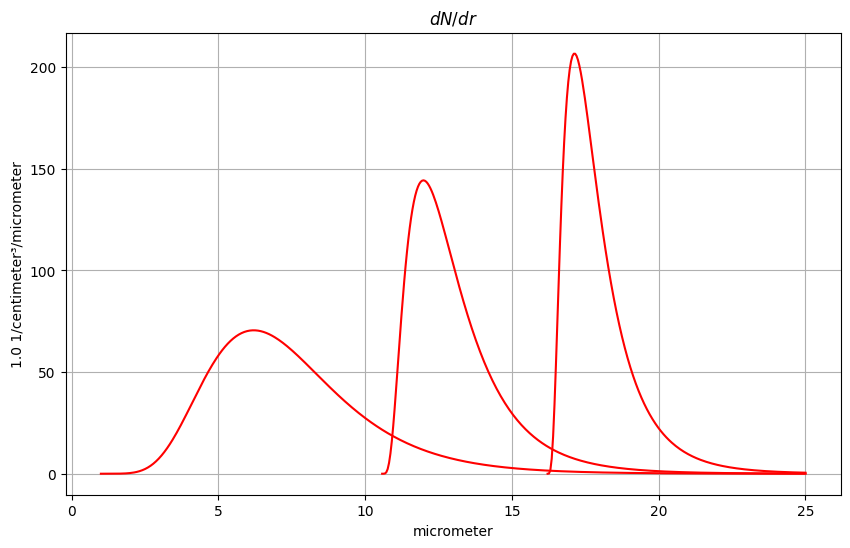

In [6]:
x = np.linspace(
            r_min.magnitude,
            r_max.magnitude,
            512
        ) *r_unit

fig, axs = pyplot.subplots(1, 1, figsize=(10,6))
axs.yaxis.set_units(1 / si.um / si.cm ** 3)
axs.xaxis.set_units(si.um)
axs.grid()
axs.set_title('$dN/dr$')
for out_step in out_steps:
    t = out_step * dt
    print('T =', t)
    pdf_t = pdfevolver(pdf, drdt, t)
    y = pdf_t(x)
    axs.plot(x, y, color='red')
pyplot.show()